# TP2 Reconstruction of DOSY NMR signals - Part I

* Authors: Mengda Li, Ségolène Martin

## 1 Introduction


Our goal of optimization: find 

$$ \bar{x} = \underset{x \in \mathbb{R}^N}{\arg\min}
\frac{1}{2} \left\lVert Kx - y \right\rVert ^2 + \beta g(x)$$

where $g \in \Gamma_0(\mathbb{R}^N)$ denotes a regularization term and $\beta ≥ 0$.

## 2 Generation of synthetic data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import exp, log
from scipy import linalg

T_MIN = 1
T_MAX = 1000
N = 200
M = 50
t_MIN = 0
t_MAX = 1.5

1. Download on the website the diffusion signal  $\bar{x}$

In [2]:
original_signal = np.loadtxt('x.txt')

2. Create $T$ using an exponential sampling strategy

In [3]:
def T_sampling(n):
    return T_MIN * exp(-(n-1)*(log(T_MIN/T_MAX)/(N-1)))

T = T_sampling(np.arange(1, N+1))

3. Display the original signal $\bar{x}$ as a function of $T$ (use log scale on the horizontal axis).

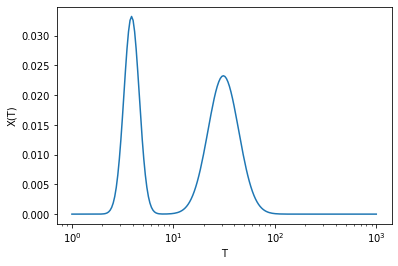

In [4]:
plt.plot(T, original_signal)
plt.xscale('log')
plt.xlabel('T')
plt.ylabel('X(T)');

4. Create $t$ using a regular sampling strategy

In [5]:
def t_sampling(m):
    return t_MIN + (m-1)/(M-1) * (t_MAX - t_MIN)
t = t_sampling(np.arange(1, M+1))

5. Construct matrix $K$

In [6]:
K = exp(-np.tensordot(t, T, axes = 0))

6. Simulate the noisy data $y = K \bar{x} + w$

In [8]:
z = K @ original_signal
sigma = 0.01 * z[0]
I_M = np.identity(M)
cov = sigma**2 * I_M
mean = np.zeros(M)

w = np.random.multivariate_normal(mean, cov)
y = z + w

7. Display the resulting noisy data $y$ as a function of $t$.

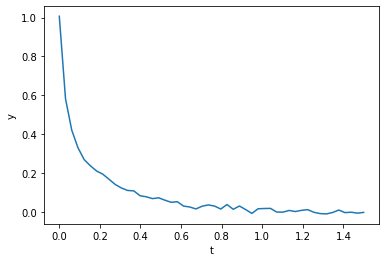

In [9]:
plt.plot(t, y)
plt.ylabel("y")
plt.xlabel('t');

## 3 Comparison of regularization strategies

* ###  Case 1: **Smoothness prior**

$$g(x) = \frac{1}{2} \lVert Dx \rVert^2$$

with $D = 
\begin{pmatrix}
    1       & 0 & 0 & \dots & -1 \\
    -1      & 1 & 0 & \dots & 0 \\
    \vdots & \ddots & \ddots \\
    0       & 0 & \dots &  -1 &1
\end{pmatrix} \in \mathbb{R}^{N \times N}$

We want to minimize the function 

\begin{align}
f(x) &= \frac{1}{2} \left\lVert Kx - y \right\rVert ^2 + 
\beta \frac{1}{2} \lVert Dx \rVert^2 \\
    & =\frac{1}{2} x^T(K^T K + \beta D^T D) x - y^T K x + \frac{1}{2}\|y\|^2
\end{align}

$f$ is differentiable as a sum of two differentiable functions, with $\forall x \in \mathbb{R}^N$, $$\nabla f(x) = (K^T K + \beta D^T D) x - K^T y$$

#### 1. Discuss the existence and uniqueness of a solution to the problem.

It is a **quadratic minimization problem**.

$x \mapsto \Vert Kx -y \Vert^2$ is convex as a composition of the convex function $\Vert . \Vert^2$ with a linear function. For the same reason $x\mapsto \Vert Dx \Vert^2$ is convex. Hence $f$ is convex. Thus there exists a solution to the problem if and only if $\nabla f$ vanishes, that is if and only if $K^Ty \in \text{Im}(K^T K + \beta D^T D)$. 

In that case $\hat{x}$ is a solution if and only if $\nabla f(\hat{x}) =0$. Thus the solution is unique if and only if $K^T K + \beta D^T D$ is invertible, and since $K^T K + \beta D^T D$ is symetric semidefinite, this condition reduces to $ K^T K + \beta D^T D  \succ 0$.

It may be resumed as follows :
* if $(K^T K + \beta D^T D) \succ 0$, then there is a unique solution, 
$$\hat{x} =(K^T K + \beta D^T D)^{-1} K^T y $$

* In the more general case when $K^T K + \beta D^T D$ is not positive definite, any solution of $(K^T K + \beta D^T D) \hat{x} = K^T y$ is optimal

* If $(K^T K + \beta D^T D) \hat{x} = K^T y$ does not have a solution, then the problem is unbounded below.

#### 2. Propose an approach to solve problem

The key is to solve the linear system
$$(K^T K + \beta D^T D) \hat{x} = K^T y \tag{*}$$
&nbsp; &nbsp;&nbsp;&nbsp;if there is a solution $\hat{x}$ for $(*)$, then it is the optimum. 

We can use `scipy.linalg.solve` to solve this system numerically if $(K^T K + \beta D^T D)$ is not singular.

**_Remark_**:
I did a small test of conditional number for the matrix $(K^T K + \beta D^T D)$. The result shows that if $\beta \in ]0, 100]$, the linear system can be solved numerically safely. Here I use `scipy.linalg.solve` which is faster and more stable than `scipy.linalg.inv`.

*The following test code is time-consumming.*

In [10]:
D = np.identity(N)
D[0, -1] = -1
for i in range(1, N):
    D[i, i-1] = -1
  
K_SQUARE = K.T @ K
D_SQUARE = D.T @ D
KY = K.T @ y

DTYPE = (K_SQUARE +  D_SQUARE).dtype

def singularity_test(beta):
    MATRIX = K_SQUARE + beta * D_SQUARE
    return np.linalg.cond(MATRIX) < 1/np.finfo(DTYPE).eps

singularity_test = np.vectorize(singularity_test)

Beta = np.linspace(0, 100, 10000)
test_result = singularity_test(Beta)

singular_index = np.where(test_result == False)
print("when \u03B2 \u2208{}, the matrix is 'singular' numerically".format(Beta[np.where(test_result == False)]))

when β ∈[0.], the matrix is 'singular' numerically


#### 3. Implement it, and display the restored signal $\bar{x}$

We show the restored signal with $\beta = 1, \beta = 10, \beta = 100$ in this question. Unfortunately, we have ill-conditioned matrix in the linear system.

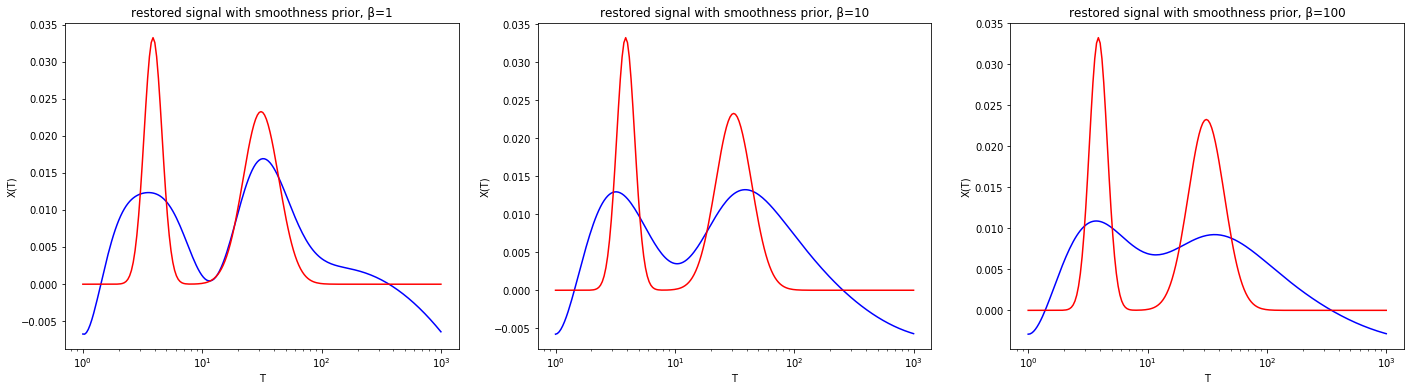

In [11]:
beta = 1

D = np.identity(N)
D[0, -1] = -1
for i in range(1, N):
    D[i, i-1] = -1
  
K_SQUARE = K.T @ K
D_SQUARE = D.T @ D
KY = K.T @ y

plt.rcParams['figure.figsize'] = [24, 6]

plt.figure()
plt.subplot(1, 3, 1)
restored_signal_smooth_1 = linalg.solve(K_SQUARE + beta * D_SQUARE, KY)
plt.plot(T, restored_signal_smooth_1, 'b-', label = "restored signql")
plt.plot(T, original_signal, 'r-', label='original signal')
plt.title('restored signal with smoothness prior, \u03B2={}'.format(beta))
plt.xscale('log')
plt.xlabel('T')
plt.ylabel('X(T)');

plt.subplot(1, 3, 2)
beta = 10
restored_signal_smooth_10 = linalg.solve(K_SQUARE + beta * D_SQUARE, KY)

plt.plot(T, restored_signal_smooth_10, 'b-', label = "restored signql")
plt.plot(T, original_signal, 'r-', label='original signal')
plt.title('restored signal with smoothness prior, \u03B2={}'.format(beta))
plt.xscale('log')
plt.xlabel('T')
plt.ylabel('X(T)');

plt.subplot(1, 3, 3)
beta = 100
restored_signal_smooth_100 = linalg.solve(K_SQUARE + beta * D_SQUARE, KY)

plt.plot(T, restored_signal_smooth_100, 'b-', label = "restored signql")
plt.plot(T, original_signal, 'r-', label='original signal')
plt.title('restored signal with smoothness prior, \u03B2={}'.format(beta))
plt.xscale('log')
plt.xlabel('T')
plt.ylabel('X(T)');

#### 4. Compute the normalized quadratic error between $\hat{x}$ and $\bar{x}$.

We show the normalized quadratic error with $\beta = 1, \beta = 10, \beta = 100$ in this question.

In [12]:
X_BAR_SQUARE = np.dot(original_signal, original_signal)

def normalized_quadratic_error(restored_signal):
    x_hat_square = np.dot(restored_signal, restored_signal)
    return (x_hat_square -2 * np.dot(original_signal, restored_signal) + X_BAR_SQUARE) / X_BAR_SQUARE

error_smooth_1 = normalized_quadratic_error(restored_signal_smooth_1)
print('error = {} with \u03B2={}'.format(error_smooth_1, 1))

error_smooth_10 = normalized_quadratic_error(restored_signal_smooth_10)
print('error = {} with \u03B2={}'.format(error_smooth_10, 10))

error_smooth_100 = normalized_quadratic_error(restored_signal_smooth_100)
print('error = {} with \u03B2={}'.format(error_smooth_100, 100))

error = 0.32318197119108594 with β=1
error = 0.43357070898027156 with β=10
error = 0.4749218498488423 with β=100


#### 5. When needed, search manually for the best choice for parameter $\beta$ in terms of reconstruction error.

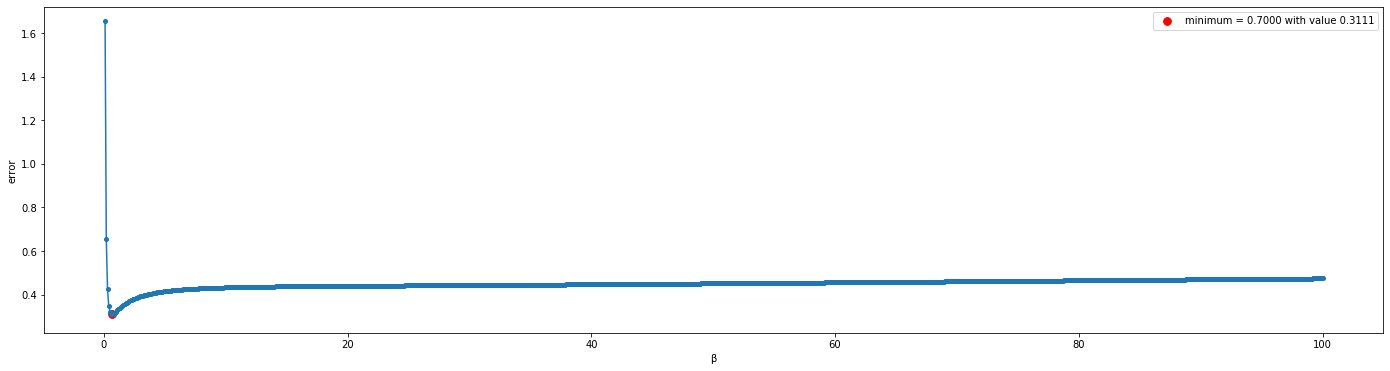

In [13]:
def error_smooth_beta(beta):
    restored_signal_smooth = linalg.solve(K_SQUARE + beta * D_SQUARE, KY)
    error_smooth = normalized_quadratic_error(restored_signal_smooth)
    return error_smooth

error_smooth_beta = np.vectorize(error_smooth_beta)

Beta = np.linspace(0.1, 100, 1000)
Error_smooth = error_smooth_beta(Beta)

plt.plot(Beta, Error_smooth, 'o-', markersize=4)
plt.xlabel('\u03B2')
plt.ylabel('error');

min_index = np.argmin(Error_smooth)
minimum = Beta[min_index]
min_val = Error_smooth[min_index]

plt.scatter(minimum, min_val, s= 60, c = 'red', label = 'minimum = {:5.4f} with value {:5.4f}'.format(minimum, min_val))
plt.legend();

* ###  Case 2: **Smoothness prior + constraints**

$$g(x) = \frac{1}{2} \lVert Dx \rVert^2 + \iota_{[\bar{x}_{min}, \bar{x}_{max}]^N}(x)$$
with $$D = 
\begin{pmatrix}
    1       & 0 & 0 & \dots & -1 \\
    -1      & 1 & 0 & \dots & 0 \\
    \vdots & \ddots & \ddots & \ddots & \vdots \\
    0       & 0 & \dots &  -1 &1
\end{pmatrix} \in \mathbb{R}^{N \times N} \quad \iota_{[\bar{x}_{min}, \bar{x}_{max}]^N}(x) =
  \begin{cases}
    0 & \text{if} \ \bar{x}_{min} <x_i< \bar{x}_{max} \ \forall i \in [1..N] \\
    +\infty & \text{otherwise}
  \end{cases}$$ 
  
Let $f(x) = \frac{1}{2} \left\lVert Kx - y \right\rVert ^2 + \beta g(x)$.
We want to solve the problem :

\begin{align}
\text{argmin}_{x \in \mathbb{R}^N} f(x)
\end{align}

#### 1. Discuss the existence and uniqueness of a solution to the problem.

$f$ is continuous on $[x_{min} , x_{max}]^N$ and take the value $+\infty$ on $\left([x_{min} , x_{max}]^N\right)^c$. So **the problem always has at least one solution** and the solutions lie in $[x_{min} , x_{max}]^N$. Since $f$ is convex and differentiable on $]x_{min} , x_{max}[^N$ with $\nabla f(x) = (K^T K + \beta D^T D) x - K^T y$ : :

* If $(K^T K + \beta D^T D) \succ 0$, $f$ is strictly convex on $[x_{min} , x_{max}]^N$. Thus the problem has an unique solution, and the solution may be in $]x_{min} , x_{max}[^N$ or on its border. 
* Otherwise, if $(K^T K + \beta D^T D)$ is not definite positive, nothing can be said about the uniqueness of the minimum.

#### 2. Propose an approach to solve problem

To solve this problem we will be using the **projected gradient method**. Indeed, solving the problem amouts to minimize the function $h:x \mapsto\frac{1}{2} \left\lVert Kx - y \right\rVert ^2 + \beta \frac{1}{2} \lVert Dx \rVert^2$ over the closed non-empty convex set $[x_{min} , x_{max}]^N$. First we make the choice of the parameters.

* $\nu$: Lipschitz constant of $\nabla h$.

We have $\nabla h(x) = (K^T K + \beta D^T D) x - K^T y$, so the best $\nu$ that can be chosen is $\nu =\Vert K^T K + \beta D^T D \Vert_2 = \rho (K^T K + \beta D^T D)$ where $\rho$ is the spectral radius. It can be computed with the package $\texttt{numpy.linalg}$.

* $\gamma \in [0, 2/\nu]$ and $\delta = 2 - \gamma \nu /2 \in ]1, 2[$.
* $\lambda_n$ a sequence in $[0, \delta]$. For simplicity we choose $\lambda_n = \delta/2$ for all $n$.
* We need to calculate $P_C$ the projection on the convex $C$. It is clear it is given by : $$P_C(x) =x_{min}\left(1_{|x_i-x_{max}|> |x_i-x_{min}|}1_{x_i \notin [x_{min},x_{max}]}\right)_{i\in [1, N]} + x_{max}\left(1_{|x_i-x_{max}|\leq |x_i-x_{min}|}1_{x_i \notin [x_{min},x_{max}]}\right)_{i\in [1, N]} + \left(x_i 1_{x_i \in [x_{min},x_{max}]}\right)_{i\in [1, N]}$$


$\frac{1}{2} x^T(K^T K + \beta D^T D) x - y^T K x + \frac{1}{2}\|y\|^2$

#### 3. Implement it, and display the restored signal $\bar{x}$

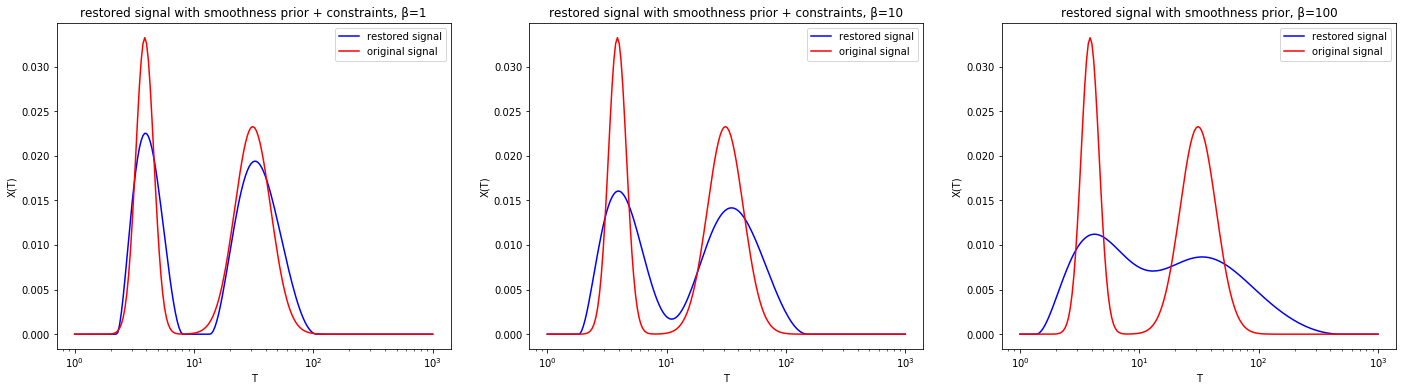

In [27]:
x_min = np.min(original_signal)
x_max = np.max(original_signal)

def proj_grad(x_0, eps, beta):  
#     h = lambda x : x.T.dot(K_SQUARE + beta * D_SQUARE).dot(x)/2 - y.T.dot(K).dot(x) + y.dot(y)/2
#     grad_h = lambda x : (K_SQUARE + beta * D_SQUARE).dot(x) - K.T.dot(y)

    MATRIX = K_SQUARE + beta * D_SQUARE
    def grad_h(x):
        return MATRIX @ x - KY
    
#     P_C = lambda x : x_min*(abs(x-x_max)> abs(x-x_min))*(x < x_min or x > x_max) + x_max*(abs(x-x_max) <= abs(x-x_min))*(x < x_min or x > x_max) + x*(x_min <= x <= x_max)
    def P_C(x):
        if x < x_min:
            return x_min
        elif x > x_max:
            return x_max
        else:
            return x
    P_C = np.vectorize(P_C)

    # Parameters
    nu = np.max(np.abs(linalg.eigvals(MATRIX)))
    gamma = (2 / nu) * 0.98
    delta = 2 - gamma*nu/2
    assert 1 < delta < 2
    lamb = delta * 0.99
  
    # Initialisation
    x = x_0
    err = 1
    iteration = 0
    MAX_ITER = 1e5
    # Itération
    while err > eps*np.linalg.norm(x) :
        if iteration > MAX_ITER:
            print('max iteration {} reached'.format(MAX_ITER))
            return x
        
        iteration += 1
        z = x-gamma*grad_h(x)
        x_new = x + lamb*(P_C(z)-x)
        err = np.linalg.norm(x_new-x)
        x = x_new

        #if iteration%100 == 0:
            #print('iter = {}, err = {}, norme x = {}'.format(iteration, err,np.linalg.norm(x)))
    
    return x

x_0 = np.ones(N)*(x_max+x_min)/2
restored_signal_constraint_1 = proj_grad(x_0, 10**(-6), 1)
restored_signal_constraint_10 = proj_grad(x_0, 10**(-6), 10)
restored_signal_constraint_100 = proj_grad(x_0, 10**(-6), 100)


plt.rcParams['figure.figsize'] = [24, 6]

plt.figure()
plt.subplot(1, 3, 1)
beta = 1
plt.plot(T, restored_signal_constraint_1, 'b-', label='restored signal')
plt.plot(T, original_signal, 'r-', label='original signal')
plt.title('restored signal with smoothness prior + constraints, \u03B2={}'.format(beta))
plt.legend()
plt.xscale('log')
plt.xlabel('T')
plt.ylabel('X(T)');

plt.subplot(1, 3, 2)
beta = 10
plt.plot(T, restored_signal_constraint_10,'b-', label='restored signal')
plt.plot(T, original_signal, 'r-', label='original signal')
plt.title('restored signal with smoothness prior + constraints, \u03B2={}'.format(beta))
plt.legend()
plt.xscale('log')
plt.xlabel('T')
plt.ylabel('X(T)');

plt.subplot(1, 3, 3)
beta = 100
plt.plot(T, restored_signal_constraint_100,'b-', label='restored signal')
plt.plot(T, original_signal, 'r-', label='original signal')
plt.title('restored signal with smoothness prior, \u03B2={}'.format(beta))
plt.legend()
plt.xscale('log')
plt.xlabel('T')
plt.ylabel('X(T)');

[ 1.44020019e-04  3.42172143e-04  3.43255095e-04  1.91128145e-04
 -7.32364704e-05 -4.11858574e-04 -7.89843586e-04 -1.17546314e-03
 -1.54022139e-03 -1.85890552e-03 -2.10961920e-03 -2.27379756e-03
 -2.33620262e-03 -2.28489782e-03 -2.11120093e-03 -1.80961432e-03
 -1.37773206e-03 -8.16123446e-04 -1.28192688e-04  6.79984975e-04]
[1.44020019e-04 3.42172143e-04 3.43255095e-04 1.91128145e-04
 4.48851590e-24 4.48851590e-24 4.48851590e-24 4.48851590e-24
 4.48851590e-24 4.48851590e-24]
[380.96541059 378.20130494 375.18453073 375.26133613 365.34833716
 368.79479998 372.07460622 372.14840554 368.86558526 365.41611504
 361.73860998 361.80339908 357.96917412 358.03100271 354.04374504
 354.10264882 349.96619399 350.02221422 332.21742112 332.26237353]


In [95]:
beta



100